In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [11]:
import torch
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()
print("Model Loaded")

Model Loaded


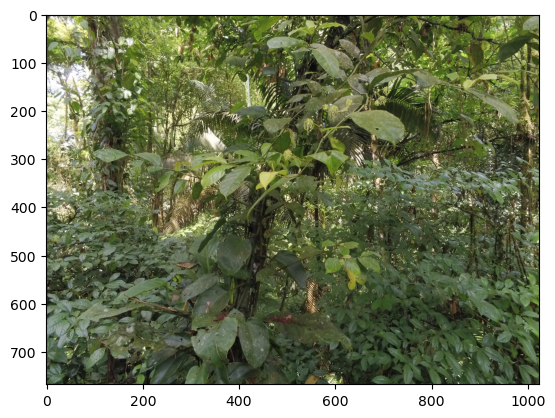

In [21]:
def load_image(path):
    full_res_image = cv2.imread(path)
    full_res_image = cv2.cvtColor(full_res_image, cv2.COLOR_BGR2RGB)

    # resize so not too big for GPU
    max_width = 1024
    height, width = full_res_image.shape[:2]
    new_width = max_width if width > max_width else width
    image_shrink_factor = new_width / width  # will be used later for sampling from full res image
    new_height = int(height * image_shrink_factor)
    image = cv2.resize(full_res_image, (new_width, new_height))

    return image, full_res_image


monteverde_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
# image_basename = "P0870381.JPG"  # fern, shrub (close-up)
# image_basename = "P0950389.JPG"  # fern, shrub, star plant (close-up)
# image_basename = "P1070401.JPG"  # jungly
# image_basename = "P1360430.JPG"  # shrubs, colorful leaves
# image_basename = "P1420437.JPG"  # epiphyte and shrubs
image_basename = "P0800374.JPG"  # vine
# image_basename = "P1480443.JPG"  # fruit, and forest floor
# image_basename = "P1540449.JPG"  # stream surrounded by bushes
# image_basename = "P1550450.JPG"  # fungus on a log and a few plants

image, full_res_image = load_image(os.path.join(monteverde_path, image_basename))
plt.imshow(image)
plt.show()

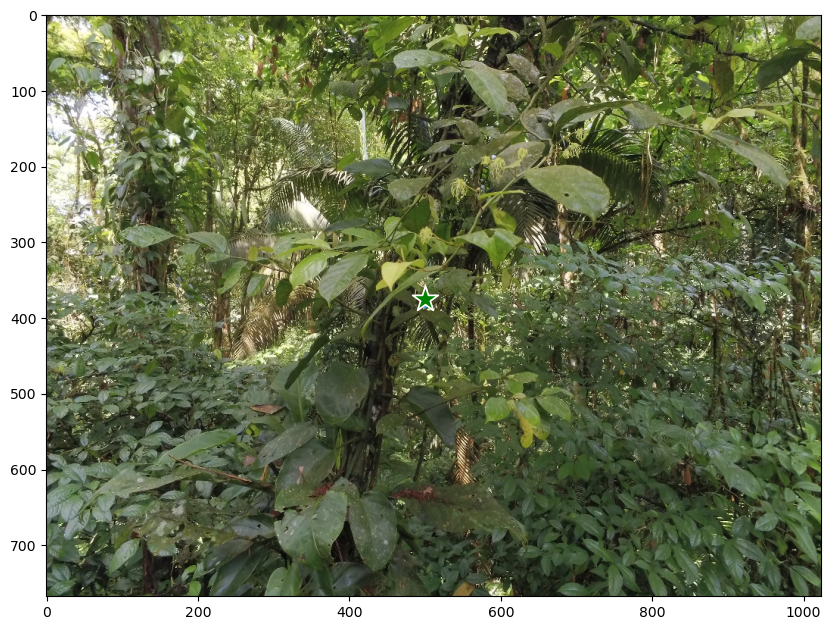

In [22]:
predictor = SamPredictor(mobile_sam)
predictor.set_image(image)
input_point = np.array([[500, 375]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_points(input_point, input_label, plt.gca())

In [1]:
mask_generator = SamAutomaticMaskGenerator(mobile_sam, stability_score_thresh=0.65, points_per_side=32)

def is_made_of_large_submasks(mask_data, k):
  """Tests if the kth mask is mostly covered by the union of submasks that are a significant size.
  If this is the case, it's probably better to use the submasks instead of this mask.
  """

  min_intersection_fraction = 0.1
  submask_union = np.full(mask_data[k]['segmentation'].shape, False)

  for i, mask_object in enumerate(mask_data):
    if i == k:
      continue

    # ignore bigger masks, probably not a submask
    if mask_object['area'] > mask_data[k]['area']:
      continue

    # ignore tiny masks
    if mask_object['area'] < min_intersection_fraction * mask_data[k]['area']:
      continue

    intersection = mask_object['segmentation'] & mask_data[k]['segmentation']
    if np.count_nonzero(intersection) / mask_data[k]['area'] > min_intersection_fraction:
      submask_union = submask_union | intersection

    # if submasks managed to cover an appreciable fraction of this mask, return true
    # from testing, "appreciable fraction" should actually be quite small
    if np.count_nonzero(submask_union) > 0.3*mask_data[k]['area']:
      return True

  # print(k, "Not covered enough - fraction covered:", np.count_nonzero(submask_union)/mask_data[k]['area'])
  return False



def filter_out_submasks(mask_data):
  # go through masks biggest -> smallest, and filter out masks that are mostly in already covered areas
  sorted_mask_data = sorted(mask_data, key=lambda x: x['area'], reverse=True)
  filtered_masks = []

  covered_area = np.full(mask_data[0]['segmentation'].shape, False)

  for i, mask_object in enumerate(sorted_mask_data):
    mask = mask_object['segmentation']

    # filter out masks that take up basically the whole image - this will be a zoom level anyways
    # this helps us still keep important smaller masks when we filter submasks out
    width_frac = mask_object['bbox'][2] / mask.shape[1]
    height_frac = mask_object['bbox'][3] / mask.shape[0]
    if width_frac > 0.9 and height_frac > 0.9:
      continue

    mask_fraction_already_covered = np.count_nonzero(mask & covered_area) / np.count_nonzero(mask)
    if mask_fraction_already_covered > 0.5:
      continue

    # filter out big masks that are mostly made up of large submasks
    area_fraction = mask_object['area'] / mask_object['segmentation'].size
    if area_fraction > 0.05 and is_made_of_large_submasks(sorted_mask_data, i):
      continue

    filtered_masks.append(mask_object)
    covered_area = covered_area | mask

  return filtered_masks



all_mask_data = mask_generator.generate(image)

# filter submasks and masks that can be broken up
mask_data = filter_out_submasks(all_mask_data)

# filter small masks
# mask_data = list(filter(lambda x: (x['area'] / image.size) >= 0.0008, mask_data))

# filter tree trunks using height/width ratio, even if not a tree trunk this is an awkward aspect ratio
# mask_data = list(filter(lambda x: (x['bbox'][3] / x['bbox'][2]) < 5, mask_data))

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(all_mask_data)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(mask_data)
plt.axis('off')
plt.show()

NameError: name 'SamAutomaticMaskGenerator' is not defined